# Visualising different normalisation

In [6]:
import utils
import video_transforms as vt
import torch
import torchvision.transforms as transforms
import torch.nn.functional as F


In [7]:
sample = './media/69241.mp4'
frames = utils.load_rgb_frames_from_video(sample, 0, 0, all=True)
print(frames.shape)

torch.Size([64, 3, 256, 256])


## Base 

In [8]:
base_mean = [0.43216, 0.394666, 0.37645]
base_std = [0.22803, 0.22145, 0.216989]
permute_fin = lambda x: x.permute(1,0,2,3) #not use for visualising
base_transform = transforms.Compose([
  transforms.Lambda(lambda x: vt.correct_num_frames(x, 16)),
  transforms.Lambda(lambda x: x.float() / 255.0),
  transforms.Lambda(lambda x: F.interpolate(x, size=(112, 112), 
                    mode='bilinear', align_corners=False)),
])
    
base_transform1 = vt.get_base()
regular_norm = vt.get_norm()

base_norm=  transforms.Compose([
  base_transform1,
  regular_norm
])

### Visualise no transformation

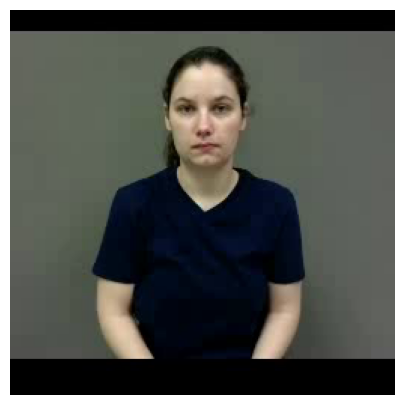

In [9]:
utils.visualise_frames(frames, 1, adapt=True)

### Visualise base transform

In [10]:
based_frames = base_transform(frames)
based_frames1 = base_transform1(frames)
print(based_frames.shape)
print(based_frames1.shape)

torch.Size([16, 3, 112, 112])
torch.Size([16, 3, 112, 112])


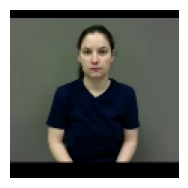

In [11]:
utils.visualise_frames(based_frames, 1, adapt=True)

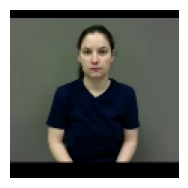

In [12]:
utils.visualise_frames(based_frames1, 1, adapt=True)


### with normalisation

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.2371149].


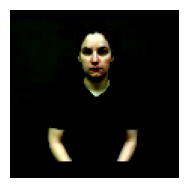

In [13]:
based_normed = base_norm(frames)
utils.visualise_frames(based_normed, 1, adapt=True)

## Random normalisation

In [14]:
augment_prob=0.5
rand_norm_aug = lambda x: vt.RandomNormalizationAugmentation(x,
  base_mean=base_mean,
  base_std=base_std,
  mean_var=0.05,
  std_var=0.03,
  prob=augment_prob
)

In [15]:


base_rand_norm = transforms.Compose([
  base_transform,
  transforms.Lambda(rand_norm_aug)
])

### visualise random normalisation

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8951892..2.3341925].


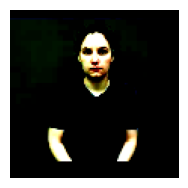

In [16]:
based_rand_normed = base_rand_norm(frames)
utils.visualise_frames(based_rand_normed, 1, adapt=True)

### Another way

In [ ]:
base_transform = vt.get_base()
regular_norm = vt.get_norm(base_mean, base_std)

rand_norm_aug =lambda x: \
  vt.RandomNormalizationAugmentation(x,
    base_mean=base_mean,
    base_std=base_std,
    mean_var=0.05,
    std_var=0.03,
    prob=0.5,                                 
  )

base_rand_norm = transforms.Compose([
  base_transform,
  rand_norm_aug
])
based_rand_normed = base_rand_norm(frames)
utils.visualise_frames(based_rand_normed, 1, adapt=True)

## Adaptive normalisation

In [17]:

base_mean = torch.Tensor(base_mean)
base_std = torch.Tensor(base_std)
print(f'base mean: {base_mean}')
print(f'base std: {base_std}')


video_mean = frames.float().mean(dim=[0,2,3])
video_std = frames.float().std(dim=[0,2,3])

video_mean = video_mean.clone().detach().float()
video_std = video_std.clone().detach().float()
print(f'Video mean: {video_mean}')
print(f'Video std: {video_std}')
adm = (1-0.4) * base_mean + 0.2 * video_mean
ads = (1 - 0.4) * base_std + 0.2 * video_std
print(f'adaptive mean: {adm}')
print(f'adaptive std: {ads}')


base mean: tensor([0.4322, 0.3947, 0.3765])
base std: tensor([0.2280, 0.2215, 0.2170])
Video mean: tensor([69.5703, 71.3979, 65.9386])
Video std: tensor([53.7432, 49.9189, 41.4943])
adaptive mean: tensor([14.1734, 14.5164, 13.4136])
adaptive std: tensor([10.8855, 10.1167,  8.4291])


### Visualise

In [18]:
adpt_norm_aug = lambda x: vd.AdaptiveNormalisation(x,
  base_mean,
  base_std,
  adaption_strength=0.3
)
adpt_norm = transforms.Compose([
  base_transform,
  transforms.Lambda(adpt_norm_aug)
])



In [19]:
adpted_normed = adpt_norm(frames)
utils.visualise_frames(adpted_normed, 1, adapt=True)

NameError: name 'vd' is not defined

# Testing transforms for contrastive learning

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.nn.functional as F

from PIL import Image
import torchvision.models.video as video_models
import torch.nn as nn
import tqdm
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter # type: ignore
import json
import gc

import train
import video_dataset as Dataset
import video_transforms as vt
import contrastive_losses as contr_l
import models


2025-07-21 12:37:47.865717: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-21 12:37:47.878351: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-21 12:37:47.890511: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-21 12:37:47.894157: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-21 12:37:47.903512: I tensorflow/core/platform/cpu_feature_guar

In [2]:
torch.manual_seed(42)

In [3]:
train_inst_path = './preprocessed/labels/asl300/train_instances_fixed_frange_bboxes_len.json'
train_clss_path = './preprocessed/labels/asl300/train_classes_fixed_frange_bboxes_len.json'
val_inst_path = './preprocessed/labels/asl300/val_instances_fixed_frange_bboxes_len.json'
val_clss_path = './preprocessed/labels/asl300/val_classes_fixed_frange_bboxes_len.json'
raw_path = '../data/WLASL2000'

In [ ]:
base_mean = [0.43216, 0.394666, 0.37645]
base_std = [0.22803, 0.22145, 0.216989]
permute_fin = vt.get_swap_ct()
base_transform = vt.get_base()
regular_norm = vt.get_norm(base_mean, base_std)
rand_norm_aug = vt.get_rand_norm_aug(base_mean, base_std)


AttributeError: module 'video_transforms' has no attribute 'get_tchw_to_cthw'

In [4]:
base_norm_fin = transforms.Compose([
  base_transform, 
  regular_norm,
  permute_fin
])

base_fin = transforms.Compose([
  base_transform,
  permute_fin
])


base_rand_norm_fin = transforms.Compose([
  base_transform,
  rand_norm_aug,
  permute_fin
])


In [5]:
contr_train_set = Dataset.ContrastiveVideoDataset(
  root=raw_path,
  instances_path=train_inst_path,  
  classes_path=train_clss_path,
  transform1=base_fin, #try contrastive learning with no normalisation
  transform2=base_norm_fin
)

contr_val_set = Dataset.ContrastiveVideoDataset(
  root=raw_path,
  instances_path=val_inst_path,
  classes_path=val_clss_path,
  transform1=base_fin, #try contrastive learning with no transformation
  transform2=base_norm_fin
)

In [ ]:
contr_train_loader = DataLoader(
  contr_train_set,
  batch_size=32, 
  shuffle=False,
  num_workers=0, #this was 4 but I previously had issues with the computer crashing (though this was with more data)
  drop_last=True
  # collate_fn=Dataset.contrastive_collate_fn
)
contr_val_loader = DataLoader(
  contr_val_set,
  batch_size=32, 
  shuffle=False,
  num_workers=0, #this was 4 but I previously had issues with the computer crashing (though this was with more data)
  drop_last=False
  # collate_fn=Dataset.contrastive_collate_fn
)

In [8]:
batch0 = next(iter(contr_train_loader))
view1, view2 = batch0

print(view1.shape)
print(view2.shape)

torch.Size([32, 3, 16, 112, 112])
torch.Size([32, 3, 16, 112, 112])


In [10]:
vid0view1 = view1[0].permute(1,0,2,3)
vid0view2 = view1[0].permute(1,0,2,3)
print(vid0view1.shape)
print(vid0view2.shape)

torch.Size([16, 3, 112, 112])
torch.Size([16, 3, 112, 112])


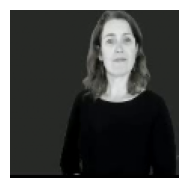

In [11]:
import utils
utils.visualise_frames(vid0view1, 1, adapt=True)

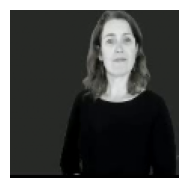

In [12]:
utils.visualise_frames(vid0view2, 1, adapt=True)

In [18]:
base_transform = vt.get_base()
train_set = Dataset.VideoDataset(
  root=raw_path,
  instances_path=train_inst_path,
  classes_path=train_clss_path,
  transform=base_transform
)

In [19]:
train_loader = DataLoader(
  train_set,
  batch_size=32, 
  shuffle=True,
  num_workers=2, #this was 4 but I previously had issues with the computer crashing (though this was with more data)
  drop_last=True
)

In [ ]:
batch1, _ = next(iter(train_loader))
print(batch0.shape)


torch.Size([32, 16, 3, 112, 112])


In [ ]:
vid1view1 = batch1[0]
print(vid1view1.shape)

torch.Size([16, 3, 112, 112])


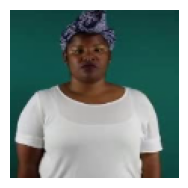

In [22]:
utils.visualise_frames(vid1view1, 1, adapt=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8756862..2.4223714].


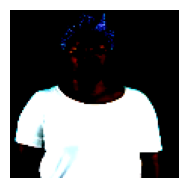

In [23]:
vid1view2 = regular_norm(vid1view1) 
utils.visualise_frames(vid1view2, 1, adapt=True)

In [24]:
context_aware_norm = vt.get_adapt_norm(prob=1)
vid1view3 = context_aware_norm(vid1view1)
utils.visualise_frames(vid1view3, 1, adapt=True)

AttributeError: module 'video_transforms' has no attribute 'get_adapt_norm'